In [35]:
import os                           # File path operations
import kagglehub                    # Kaggle datasets 
import glob                         # File pattern matching
import numpy as np                  # Numerical operations
import matplotlib.pyplot as plt     # Plotting
import pandas as pd                 # Data manipulation
import seaborn as sns               # Statistical data visualization

In [36]:
def download_data() -> pd.DataFrame:
    
    path = kagglehub.dataset_download('radheshyamkollipara/bank-customer-churn')
    
    # Look for CSV files in the downloaded directory
    csv_files = glob.glob(os.path.join(path, '*.csv'))
    
    if not csv_files:
        raise FileNotFoundError(f'No CSV files found in {path}')
    
    if len(csv_files) > 1:
        print(f'Multiple CSV files found: {[os.path.basename(f) for f in csv_files]}')
        print(f'Using the first one: {os.path.basename(csv_files[0])}')
    
    # Load and return the DataFrame directly
    df = pd.read_csv(csv_files[0])
    print(f'Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns')
    return df

In [37]:
df = download_data()
df.head()

Data loaded successfully: 10000 rows, 18 columns


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [38]:
# Check for missing values

df.isnull().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [39]:
# Select relevant columns for analysis

df = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Complain', 'Exited', 'Point Earned', 'IsActiveMember', 'HasCrCard']]

In [40]:
from sklearn.preprocessing import StandardScaler

# StandardScaler for scaling numerical features - scales features to have mean=0 and variance=1
scaler = StandardScaler()

# Scale the numerical features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Complain,Exited,Point Earned,IsActiveMember,HasCrCard
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,-0.721130,1,1,-0.630839,1,1
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,-0.009816,1,0,-0.666251,1,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,-0.009816,1,1,-1.015942,0,1
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,1.412812,0,0,-1.135457,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,1.412812,0,0,-0.803472,1,1


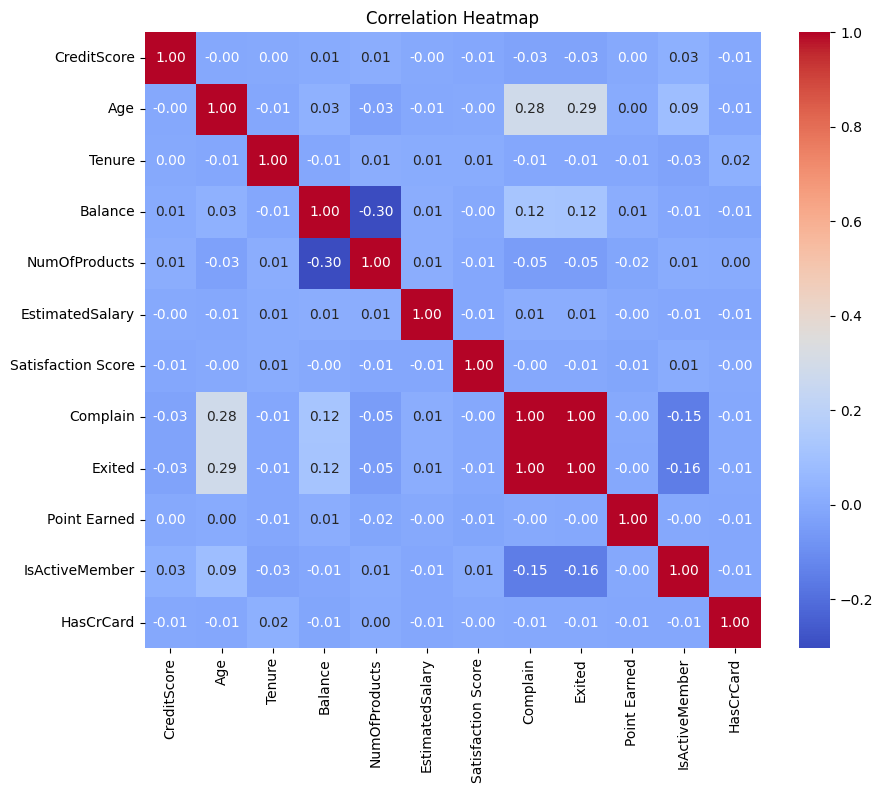

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [42]:
# Column 'Complain' has correlation with 'Exited' if 1.00 - that means every customer who complained exited
# We can drop 'Complain' as it does not add any new information to the model and is basically a duplicate of 'Exited'

df = df.drop('Complain', axis=1)

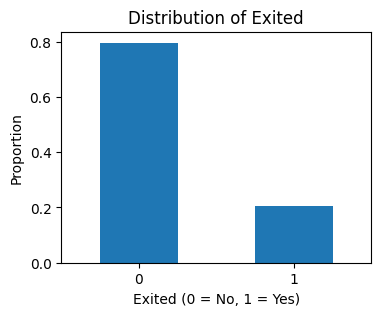

In [43]:
# Let's check the distribution of the target variable 'Exited'

plt.figure(figsize=(4, 3))
df['Exited'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Exited')
plt.xticks(rotation=0)
plt.xlabel('Exited (0 = No, 1 = Yes)')
plt.ylabel('Proportion')
plt.show()

In [44]:
# First let's split the data into features and target variable

y = df['Exited']
x = df.drop('Exited', axis=1)

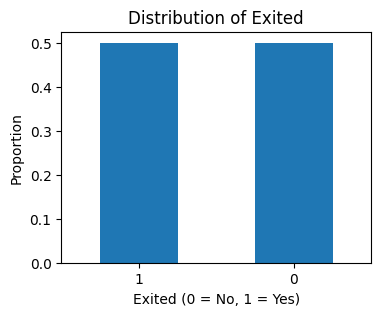

In [45]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_resampled, y_resampled = smote.fit_resample(x, y)

# SMOTE over-sampling to balance the dataset
# This will create synthetic samples for the minority class to balance the dataset

plt.figure(figsize=(4, 3))
y_resampled.value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Exited')
plt.xticks(rotation=0)
plt.xlabel('Exited (0 = No, 1 = Yes)')
plt.ylabel('Proportion')
plt.show()

In [46]:
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

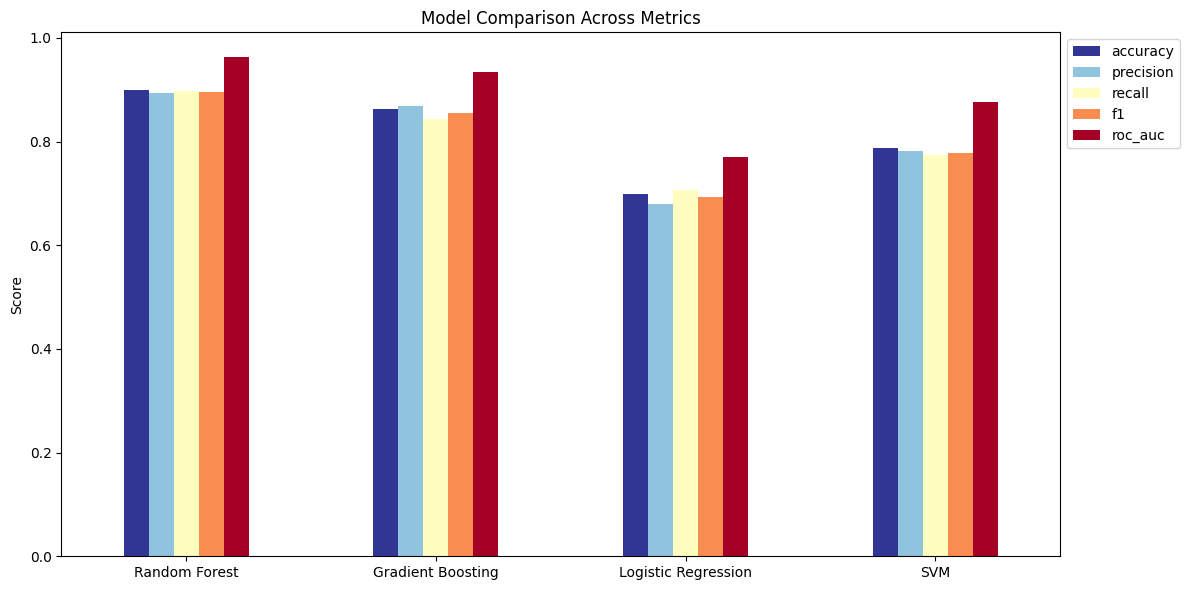

In [47]:
# Let's now see which model performs best on this dataset.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

model_results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(x_train, y_train)

    # Predict probabilities and classes
    y_pred_proba_model = model.predict_proba(x_test)[:, 1]
    y_pred_model = (y_pred_proba_model > 0.5).astype(int)
    
    # Calculate metrics
    model_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred_model),
        'precision': precision_score(y_test, y_pred_model),
        'recall': recall_score(y_test, y_pred_model),
        'f1': f1_score(y_test, y_pred_model),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_model)
    }

# Visualize model comparison
comparison_df = pd.DataFrame(model_results).T                               # .T to transpose the DataFrame for better readability
comparison_df.plot(kind='bar', figsize=(12, 6), colormap='RdYlBu_r')
plt.title('Model Comparison Across Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [48]:
# RandomForestClassifier performed the best in terms of ROC AUC, precision, recall, and F1 score.
# Now let's perform hyperparameter tuning on the RandomForestClassifier to improve its performance.

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees in the forest
    'max_depth': [10, 20, None],           # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],       # Minimum samples needed to split a node
    'min_samples_leaf': [1, 2, 4]          # Minimum samples required in a leaf node
}

# Smaller grid for demonstration
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),               # RandomForestClassifier with random state for reproducibility
    param_grid=param_grid,                                 # param_grid
    cv=3,                                                  # Cross-validation (it means the data will be split into 3 parts for training and validation)
    scoring=['roc_auc', 'precision', 'recall', 'f1'],      # Metrics to use
    n_jobs=-2,                                             # Use all available cores for parallel processing (1 = uses one core, -1 = uses all cores, -2 = uses all cores except 1)
    refit='roc_auc'                                        # Refit the model using the best ROC AUC score
)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-2,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='roc_auc', scoring=['roc_auc', 'precision', 'recall', 'f1'])

In [49]:
# Visualize hyperparameter tuning results
results_df = pd.DataFrame(grid_search.cv_results_)

results_df['mean_combined_rank'] = results_df[['rank_test_roc_auc', 'rank_test_precision', 'rank_test_recall', 'rank_test_f1']].mean(axis=1)
results_df = results_df.sort_values(by='mean_combined_rank', ascending=True)

results_df = results_df[['mean_combined_rank', 'mean_fit_time', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'mean_test_roc_auc', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']].reset_index(drop=True)

results_df.head(5)

,mean_combined_rank,mean_fit_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_roc_auc,mean_test_precision,mean_test_recall,mean_test_f1
0,1.50,5.418401,None,1,2,200,0.949100,0.892320,0.871499,0.881763
1,1.50,7.105043,None,1,2,300,0.949537,0.891343,0.871811,0.881442
2,3.25,2.430353,None,1,2,100,0.948511,0.891237,0.871032,0.881001
3,4.25,6.307973,20,1,2,300,0.948407,0.889640,0.870411,0.879885
4,5.50,1.889255,20,1,2,100,0.947160,0.887172,0.871188,0.879082


In [50]:
# Print the best model configuration for each metric from the grid search results
best_models = {}

for metric in ['roc_auc', 'precision', 'recall', 'f1']:
    best_idx = results_df[f'mean_test_{metric}'].idxmax()
    best_score = results_df.loc[best_idx, f'mean_test_{metric}']
    best_params = f"n_est={results_df.loc[best_idx, 'param_n_estimators']}, depth={results_df.loc[best_idx, 'param_max_depth']}, min_samples_split={results_df.loc[best_idx, 'param_min_samples_split']}, min_samples_leaf={results_df.loc[best_idx, 'param_min_samples_leaf']}"
    
    best_models[metric] = {
        'score': best_score,
        'params': best_params
    }

print("\nSummary of Best Models:")
for metric, info in best_models.items():
    print(f"{metric.upper()}: {info['score']:.4f} ({info['params']})")


Summary of Best Models:
ROC_AUC: 0.9495 (n_est=300, depth=None, min_samples_split=2, min_samples_leaf=1)
PRECISION: 0.8923 (n_est=200, depth=None, min_samples_split=2, min_samples_leaf=1)
RECALL: 0.8718 (n_est=300, depth=None, min_samples_split=2, min_samples_leaf=1)
F1: 0.8818 (n_est=200, depth=None, min_samples_split=2, min_samples_leaf=1)


In [51]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=results_df.iloc[0]['param_n_estimators'],
    max_depth=results_df.iloc[0]['param_max_depth'],
    min_samples_split=results_df.iloc[0]['param_min_samples_split'],
    min_samples_leaf=results_df.iloc[0]['param_min_samples_leaf'],
    random_state=42
)

rf.fit(x_train, y_train)

RandomForestClassifier(min_samples_leaf=np.int64(1),
                       min_samples_split=np.int64(2),
                       n_estimators=np.int64(200), random_state=42)

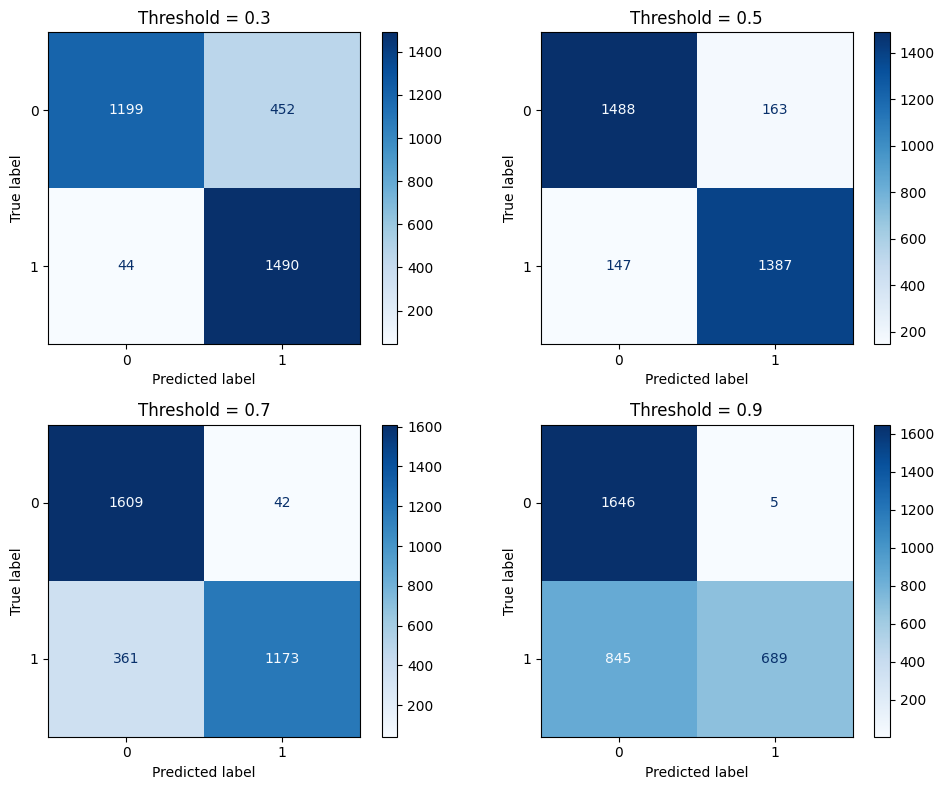

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_proba = rf.predict_proba(x_test)[:, 1]

# Confusion Matrix with different thresholds
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
thresholds_to_plot = [0.3, 0.5, 0.7, 0.9]

for i, threshold in enumerate(thresholds_to_plot):
    row, col = i // 2, i % 2
    y_pred_thresh = (y_pred_proba > threshold).astype(int)
    
    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_thresh, ax=axes[row, col], cmap='Blues'
    )
    axes[row, col].set_title(f'Threshold = {threshold}')

plt.tight_layout()
plt.show()


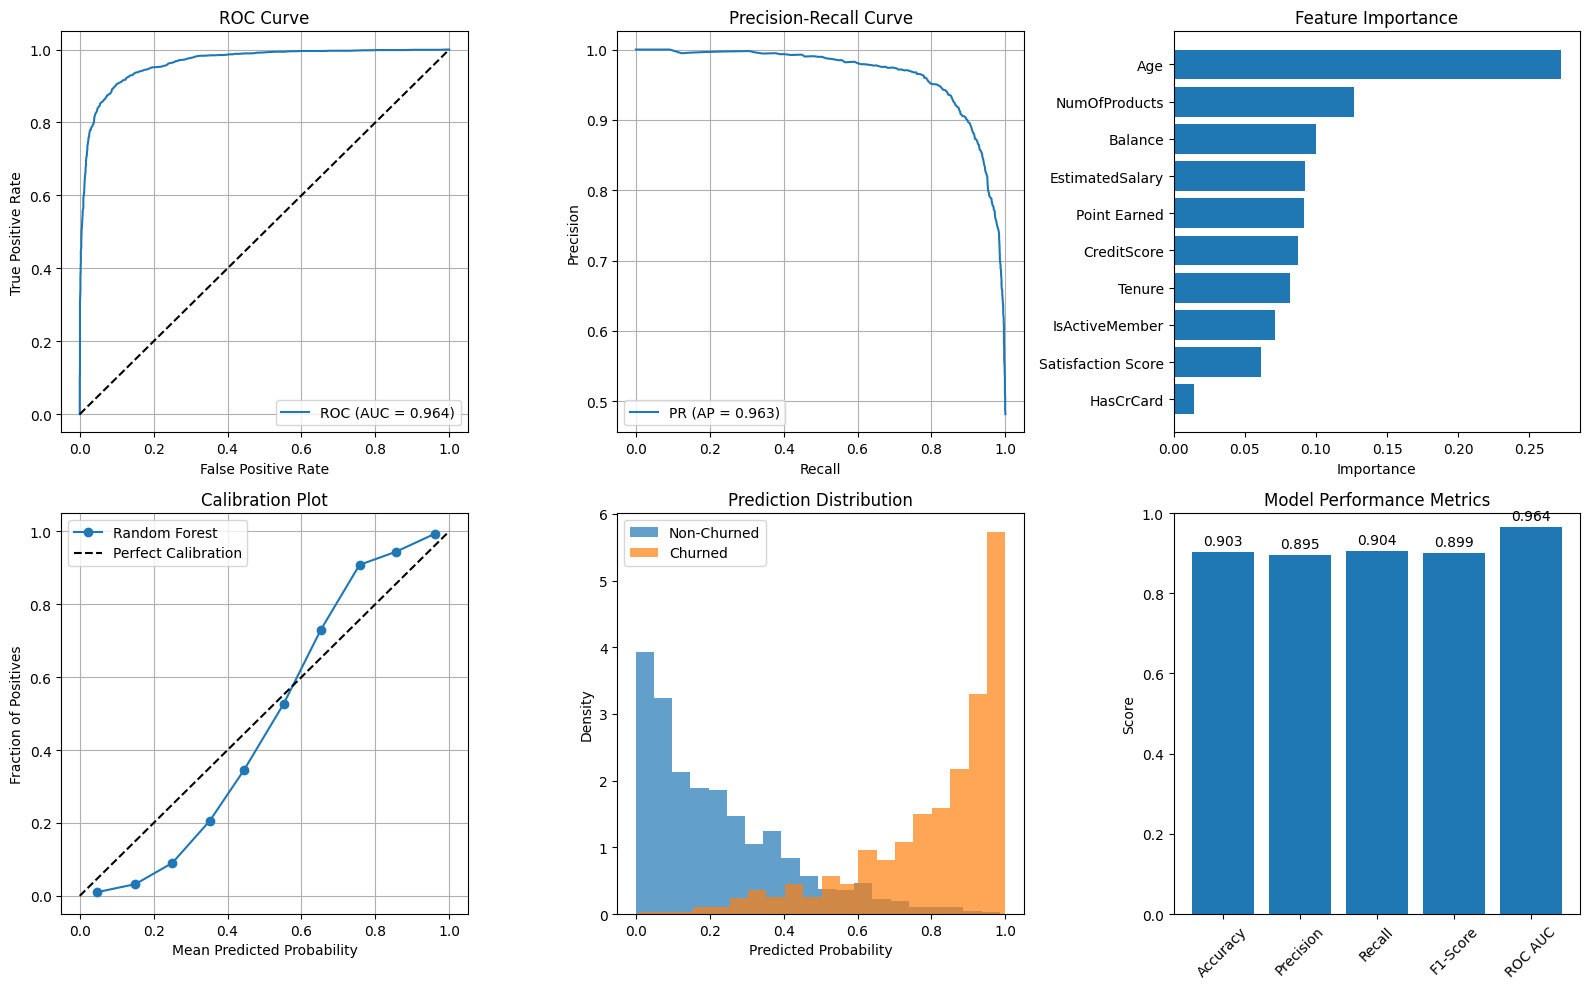

In [53]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
from sklearn.calibration import calibration_curve

y_pred_class = (y_pred_proba > 0.5).astype(int)

# Model Performance Summary Dashboard
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
axes[0, 0].plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap_score = average_precision_score(y_test, y_pred_proba)
axes[0, 1].plot(recall, precision, label=f'PR (AP = {ap_score:.3f})')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Feature Importance
feature_importance = pd.DataFrame({
    'feature': x.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

axes[0, 2].barh(feature_importance['feature'], feature_importance['importance'])
axes[0, 2].set_xlabel('Importance')
axes[0, 2].set_title('Feature Importance')

# 4. Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
axes[1, 0].plot(prob_pred, prob_true, marker='o', label='Random Forest')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
axes[1, 0].set_xlabel('Mean Predicted Probability')
axes[1, 0].set_ylabel('Fraction of Positives')
axes[1, 0].set_title('Calibration Plot')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 5. Prediction Distribution
axes[1, 1].hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='Non-Churned', density=True)
axes[1, 1].hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Churned', density=True)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Prediction Distribution')
axes[1, 1].legend()

# 6. Performance Metrics Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
scores = [
    accuracy_score(y_test, y_pred_class),
    precision_score(y_test, y_pred_class),
    recall_score(y_test, y_pred_class),
    f1_score(y_test, y_pred_class),
    roc_auc_score(y_test, y_pred_proba)
]

bars = axes[1, 2].bar(metrics, scores, color=['#1f77b4'])
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Model Performance Metrics')
axes[1, 2].set_ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

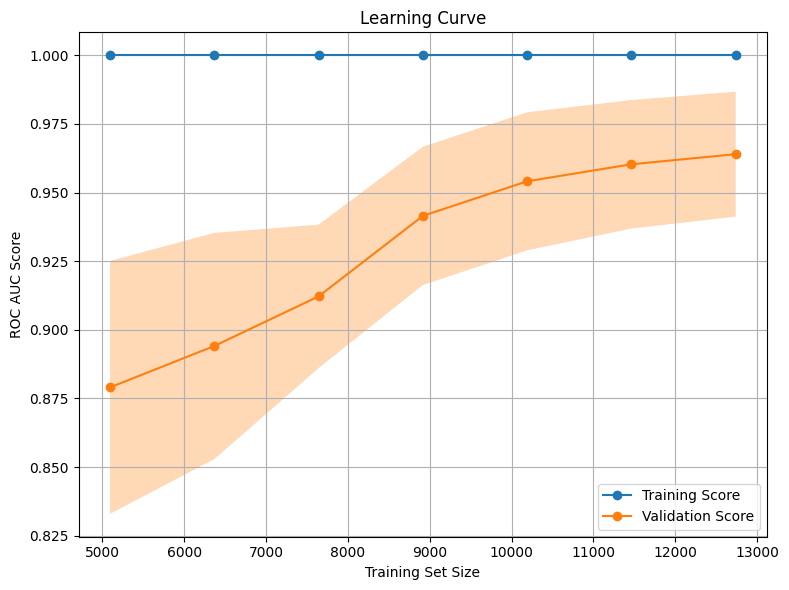

In [54]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    rf, x_resampled, y_resampled,                           # Model and data
    train_sizes=np.linspace(0.1, 1.0, 10),                  # Tests 10%, 20%, 30%... up to 100% of data
    cv=5,                                                   # 5-fold cross-validation
    scoring='roc_auc',                                      # Scoring metric
    n_jobs=-2                                               # -2 to leave one core free for the system
)

# Plot learning curves
plt.figure(figsize=(8, 6))

# plot train_scores
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')

# plot val_scores
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')

# create shaded areas for confidence intervals
plt.fill_between(train_sizes, 
                 np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), 
                 alpha=0.3)
plt.fill_between(train_sizes, 
                 np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                 np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), 
                 alpha=0.3)

plt.xlabel('Training Set Size')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()